In [1]:
import numpy as np 
import os
import keras
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from PIL import Image
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
import os

# Walk through  directory and list number of files
for dirpath, dirnames, filenames in os.walk("/kaggle/input/kidney-ct-scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")



There are 4 directories and 0 images in '/kaggle/input/kidney-ct-scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'.
There are 0 directories and 3709 images in '/kaggle/input/kidney-ct-scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst'.
There are 0 directories and 2283 images in '/kaggle/input/kidney-ct-scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor'.
There are 0 directories and 1377 images in '/kaggle/input/kidney-ct-scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone'.
There are 0 directories and 5077 images in '/kaggle/input/kidney-ct-scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal'.


In [3]:
import pathlib
import numpy as np
data_dir = pathlib.Path("/kaggle/input/kidney-ct-scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['Cyst' 'Normal' 'Stone' 'Tumor']


In [4]:
class_labels = ['Cyst','Normal','Stone','Tumor']

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img


Image shape: (646, 798, 3)


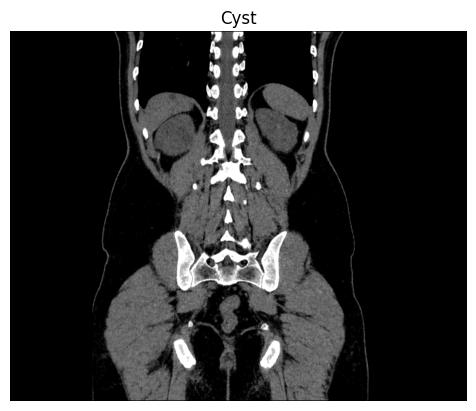

In [6]:
img = view_random_image(target_dir="/kaggle/input/kidney-ct-scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/",
                        target_class="Cyst")

In [7]:
img.shape

(646, 798, 3)

In [8]:
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to create dataframe with file paths and labels
def create_dataframe(data_path):
    filepaths = []
    labels = []

    for fold in os.listdir(data_path):
        f_path = os.path.join(data_path, fold)
        if os.path.isdir(f_path):
            imgs = os.listdir(f_path)
            for img in imgs:
                img_path = os.path.join(f_path, img)
                filepaths.append(img_path)
                labels.append(fold)

    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')
    return pd.concat([fseries, lseries], axis=1)

# Define the directory where your images are stored
data_dir = '/kaggle/input/kidney-ct-scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# Create the dataframe from the dataset directory
df = create_dataframe(data_dir)

# Step 1: Split into 70% training and 30% dummy, stratifying by labels
train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=42, stratify=df['Labels'])

# Step 2: Split dummy_df into 20% testing and 10% validation, stratifying by labels
test_df, valid_df = train_test_split(dummy_df, train_size=2/3, shuffle=True, random_state=42, stratify=dummy_df['Labels'])        

# Image data preprocessing and augmentation
image_size = [224, 224]
tf.random.set_seed(42)

# Define ImageDataGenerator with augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # The following line is optional; you can add your own validation split if needed
    validation_split=0.2
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use validation split
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test data generators
train_data = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=image_size,
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    seed=42
)

valid_data = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=image_size,
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False,
    seed=42
)
test_data = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=image_size,
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False,
    seed=42
)

Found 8712 validated image filenames belonging to 4 classes.
Found 1245 validated image filenames belonging to 4 classes.
Found 2489 validated image filenames belonging to 4 classes.


In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

BATCH_SIZE = 32
IMAGE_SIZE = [224, 224]
CHANNELS = 4

# Load the base model (VGG19)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
#x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(4, activation='softmax')(x)  # Multi-class classification with 2 classes

# Final model
model_vgg16 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model_vgg16.summary()

history = model_vgg16.fit(
    train_data,
    epochs=5,  # You can adjust the number of epochs
    validation_data=valid_data
)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


273/273 ━━━━━━━━━━━━━━━━━━━━ 2017s 7s/step - accuracy: 0.5504 - loss: 1.5577 - val_accuracy: 0.8120 - val_loss: 0.5249
Epoch 2/5
273/273 ━━━━━━━━━━━━━━━━━━━━ 2018s 7s/step - accuracy: 0.7477 - loss: 0.6679 - val_accuracy: 0.8177 - val_loss: 0.4854
Epoch 3/5
273/273 ━━━━━━━━━━━━━━━━━━━━ 2061s 7s/step - accuracy: 0.7716 - loss: 0.5927 - val_accuracy: 0.8892 - val_loss: 0.2969
Epoch 4/5
273/273 ━━━━━━━━━━━━━━━━━━━━ 2025s 7s/step - accuracy: 0.8075 - loss: 0.4978 - val_accuracy: 0.8940 - val_loss: 0.3095
Epoch 5/5
273/273 ━━━━━━━━━━━━━━━━━━━━ 1988s 7s/step - accuracy: 0.8209 - loss: 0.4659 - val_accuracy: 0.9028 - val_loss: 0.2938


In [10]:
test_loss, test_accuracy = model_vgg16.evaluate(test_data)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 490s 6s/step - accuracy: 0.8884 - loss: 0.3285
Test Loss: 0.3205884099006653, Test Accuracy: 0.8895138502120972


In [11]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();



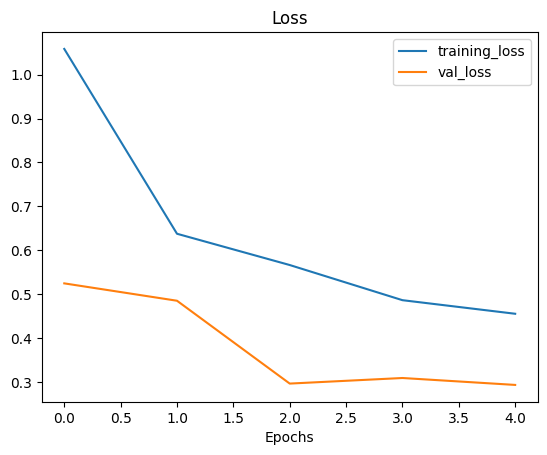

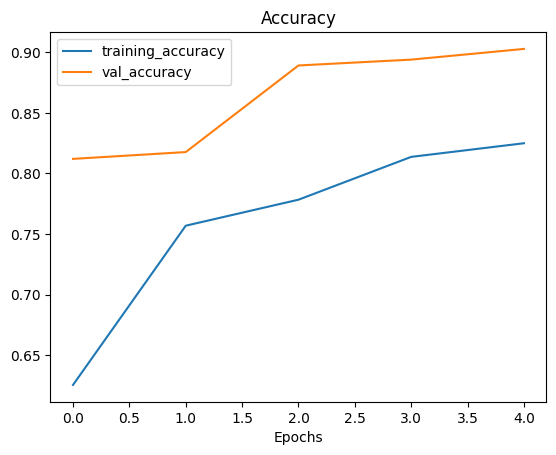

In [12]:
plot_loss_curves(history)

In [13]:
model_vgg16.save('KidneyCTscan.h5')

In [14]:
def load_and_prep_image(filename, img_shape=224):
    """
    Reads an image from filename, turns it into a tensor
    and reshapes it to (img_shape, img_shape, colour_channel).
    """
    # Read in target file (an image)
    img = tf.io.read_file(filename)

    # Decode the read file into a tensor & ensure 3 colour channels
    img = tf.image.decode_image(img, channels=3)

    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size=[img_shape, img_shape])

    # Rescale the image (get all values between 0 and 1)
    img = img / 255.

    # Add batch dimension (model expects shape (batch_size, height, width, channels))
    img = tf.expand_dims(img, axis=0)
    
    return img

In [15]:
test = load_and_prep_image("/kaggle/input/kidney-ct-scan/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (1001).jpg")

In [16]:
import tensorflow as tf
import numpy as np
# Your class labels
class_labels = ['Cyst','Normal','Stone','Tumor']

saved_model = tf.keras.models.load_model('/kaggle/working/KidneyCTscan.h5')

# Make a prediction on our custom image
prediction=saved_model.predict(test)
predicted_class = np.argmax(prediction, axis=-1)

# Map the predicted class index to the class label
predicted_class_label = class_labels[predicted_class[0]]

print(f"Predicted class: {predicted_class_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
Predicted class: Tumor


In [17]:
import tensorflow as tf
print(tf.__version__)


2.16.1


In [18]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions for the test dataset
y_pred_probs = model_vgg16.predict(test_data)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)       # Convert probabilities to class predictions

# Get true labels
y_true = test_data.classes  # True labels

# Class labels (use test_data.class_indices to map indices to class names if needed)
class_labels = list(test_data.class_indices.keys())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print(report)


78/78 ━━━━━━━━━━━━━━━━━━━━ 492s 6s/step
              precision    recall  f1-score   support

        Cyst     0.8261    0.9474    0.8826       742
      Normal     0.9133    0.9754    0.9433      1015
       Stone     0.8821    0.6800    0.7680       275
       Tumor     0.9766    0.7309    0.8360       457

    accuracy                         0.8895      2489
   macro avg     0.8995    0.8334    0.8575      2489
weighted avg     0.8955    0.8895    0.8861      2489



In [19]:
import sys
print(sys.version)


3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]


Found 8712 validated image filenames belonging to 4 classes.
Found 1245 validated image filenames belonging to 4 classes.
Found 2489 validated image filenames belonging to 4 classes.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

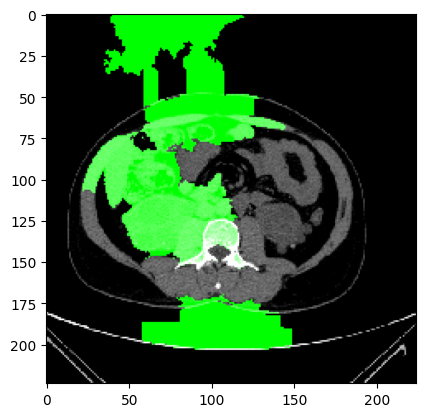

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_size=[224,224]
import tensorflow as tf
import numpy as np

from lime import lime_image
import matplotlib.pyplot as plt

# Set the seed
tf.random.set_seed(42)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # The following line is optional; you can add your own validation split if needed
    validation_split=0.2
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use validation split
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test data generators
train_data = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=image_size,
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    seed=42
)

valid_data = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=image_size,
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False,
    seed=42
)

test_data = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=image_size,
    batch_size=32,
    class_mode="categorical",
    color_mode="rgb",
    shuffle=False,
    seed=42
)
saved_model = tf.keras.models.load_model('/kaggle/working/KidneyCTscan.h5')
image_shape = (224,224, 3)

explainer = lime_image.LimeImageExplainer()

# Get a single image and its true label
x_test, y_test = next(test_data)
image = x_test[0]  # Take the first image in the batch

# Define the predict function for LIME
def predict_fn(images):
    # Normalize images (to match model preprocessing)
    images = images / 255.0  # Ensures images are between 0 and 1
    return saved_model.predict(images)

# Explain the model's prediction on the first image
explanation = explainer.explain_instance(image.astype('double'), predict_fn, top_labels=5, hide_color=0, num_samples=1000)

# Visualize the explanation for the top class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

# Display the mask overlaid on the image
plt.imshow(temp)
plt.show()